In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np
from peft import PeftModel
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from peft import LoraConfig, get_peft_model, TaskType, prepare_model_for_kbit_training
from sklearn.metrics import accuracy_score, classification_report
from transformers import (
    AutoModelForSequenceClassification,
    AutoModel,
    AutoTokenizer,
    CLIPModel,
    CLIPProcessor,
    Trainer,
    TrainingArguments,
    pipeline,
    EarlyStoppingCallback
)

/home/atarsander/Programs/anaconda3/envs/ssne/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_data = pd.read_csv("data/hate_train.csv")
train_data.head()

,sentence,label
0,Dla mnie faworytem do tytułu będzie Cracovia. ...,0
1,@anonymized_account @anonymized_account Brawo ...,0
2,"@anonymized_account @anonymized_account Super,...",0
3,@anonymized_account @anonymized_account Musi. ...,0
4,"Odrzut natychmiastowy, kwaśna mina, mam problem",0


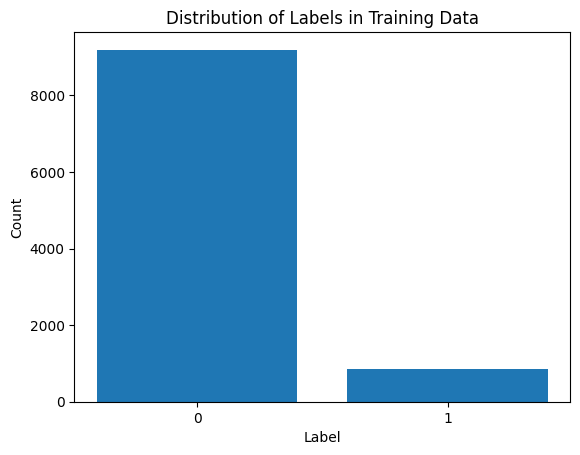

In [3]:
label_counts = train_data['label'].value_counts()
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels in Training Data')
plt.xticks([0, 1]) 
plt.show()

In [4]:
max_len = train_data["sentence"].apply(len).max()
print(f"Maximum sentence length: {max_len}")

Maximum sentence length: 214


In [5]:
class CustomTextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def set_tokenizer(self, tokenizer):
        self.tokenizer = tokenizer

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt",
        )

        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long),
        }

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
model_name_roberta = "xlm-roberta-large"
tokenizer = AutoTokenizer.from_pretrained(model_name_roberta)

In [8]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_data["sentence"], train_data["label"], test_size=0.15, random_state=42, stratify=train_data["label"]
)

In [9]:
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(train_data["label"]), y=train_data["label"])
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

print(class_weights)

tensor([0.5463, 5.8995], device='cuda:0')


In [10]:
train_dataset = CustomTextClassificationDataset(
    texts=train_texts.tolist(),
    labels=train_labels.tolist(),
    tokenizer=tokenizer,
)
val_dataset = CustomTextClassificationDataset(
    texts=val_texts.tolist(),
    labels=val_labels.tolist(),
    tokenizer=tokenizer,
)

In [11]:
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=32,  
    lora_alpha=32,
    target_modules=["query", "value"],  
    lora_dropout=0.1,
    bias="none",
)

In [12]:
model = AutoModelForSequenceClassification.from_pretrained(model_name_roberta, num_labels=2)
model = prepare_model_for_kbit_training(model)
# model = get_peft_model(model, lora_config)
model = PeftModel.from_pretrained(model, "./lora_results_2/checkpoint-76806")
model.config.label2id = {0: 0, 1: 1}
model.config.id2label = {0: "positive", 1: "negative"}
model.config.label_names = ["labels"]
model.to(device)
print(model)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): XLMRobertaForSequenceClassification(
      (roberta): XLMRobertaModel(
        (embeddings): XLMRobertaEmbeddings(
          (word_embeddings): Embedding(250002, 1024, padding_idx=1)
          (position_embeddings): Embedding(514, 1024, padding_idx=1)
          (token_type_embeddings): Embedding(1, 1024)
          (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): XLMRobertaEncoder(
          (layer): ModuleList(
            (0-23): 24 x XLMRobertaLayer(
              (attention): XLMRobertaAttention(
                (self): XLMRobertaSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=1024, out_features=1024, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
     

In [13]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {trainable_params:,}")

Number of trainable parameters: 1,051,650


In [19]:
class WeightedLossTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss


In [ ]:
training_args = TrainingArguments(
    output_dir="./lora_results_2",
    num_train_epochs=20,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    logging_dir="./lora_logs_2",
    logging_steps=5000,
    save_strategy="epoch",
    eval_strategy="epoch",
    load_best_model_at_end=True,         
    metric_for_best_model="eval_loss",    
    greater_is_better=False,
    learning_rate=5e-5,
    fp16=True,  
)

trainer = WeightedLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    class_weights=class_weights,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [16]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,0.847240
2,0.778900,0.620821
3,0.619700,0.585643
4,0.506900,0.655266
5,0.481800,0.688369
6,0.413900,0.604725
7,0.413900,0.586632
8,0.397700,0.537869
9,0.359300,0.609466
10,0.333200,0.562897


TrainOutput(global_step=76806, training_loss=0.355220379166481, metrics={'train_runtime': 1687.0571, 'train_samples_per_second': 101.17, 'train_steps_per_second': 50.585, 'total_flos': 3.628414168521523e+16, 'train_loss': 0.355220379166481, 'epoch': 18.0})

In [14]:
def measure_accuracy(model, dataset, device):
    model.eval()
    all_predictions = []
    all_labels = []

    val_dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)


            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=-1)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())


    accuracy = accuracy_score(all_labels, all_predictions)
    report = classification_report(all_labels, all_predictions, target_names=["positive", "negative"])
    print(f"Model Accuracy: {accuracy:.4f}")
    print(report)


In [15]:
measure_accuracy(model, val_dataset, device)

Model Accuracy: 0.9303
              precision    recall  f1-score   support

    positive       0.96      0.97      0.96      1379
    negative       0.61      0.52      0.56       128

    accuracy                           0.93      1507
   macro avg       0.78      0.74      0.76      1507
weighted avg       0.93      0.93      0.93      1507



In [16]:
model_name_allegro = "allegro/herbert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name_allegro)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name_allegro, num_labels=2)
model = prepare_model_for_kbit_training(model)
# model = get_peft_model(model, lora_config)
model = PeftModel.from_pretrained(model, "./lora_results_allegro/checkpoint-76806")
model.config.label2id = {0: 0, 1: 1}
model.config.id2label = {0: "positive", 1: "negative"}
model.config.label_names = ["labels"]
model.to(device)
print(model)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allegro/herbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): BertForSequenceClassification(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(50000, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default

In [36]:
train_dataset.set_tokenizer(tokenizer)
val_dataset.set_tokenizer(tokenizer)

In [40]:
training_args = TrainingArguments(
    output_dir="./lora_results_allegro",
    num_train_epochs=20,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    logging_dir="./lora_logs_allegro",
    logging_steps=5000,
    save_strategy="epoch",
    eval_strategy="epoch",
    load_best_model_at_end=True,         
    metric_for_best_model="eval_loss",    
    greater_is_better=False,
    learning_rate=5e-5,
    fp16=True,  
)

trainer = WeightedLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    class_weights=class_weights,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=7)]
)

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [41]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,0.599936
2,0.408200,0.586091
3,0.379400,0.602347
4,0.330500,0.605602
5,0.344200,0.598935
6,0.315300,0.605399
7,0.315300,0.574055
8,0.277300,0.544470
9,0.245700,0.660050
10,0.244100,0.625333


TrainOutput(global_step=64005, training_loss=0.2660412682526634, metrics={'train_runtime': 710.1847, 'train_samples_per_second': 240.332, 'train_steps_per_second': 120.166, 'total_flos': 8536335929210880.0, 'train_loss': 0.2660412682526634, 'epoch': 15.0})

In [ ]:
measure_accuracy(model, val_dataset, device)

Model Accuracy: 0.9277
              precision    recall  f1-score   support

    positive       0.96      0.96      0.96      1379
    negative       0.58      0.55      0.56       128

    accuracy                           0.93      1507
   macro avg       0.77      0.75      0.76      1507
weighted avg       0.93      0.93      0.93      1507

